In [55]:
import re
import random
import pandas as pd
import hashlib

In [56]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [57]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Todd Ideas,249.876005,16.658400,15
Powershell,513.571085,51.357108,10
Terraform,655.560285,26.222411,25
Azure Functions,745.501554,67.772869,11
FSLogix,1197.428221,49.892843,24
Email Auth and Security,1204.119603,92.624585,13
Azure Functions + Visual Studio,1236.096255,88.292590,14
Audit Report Tracker (Sharepoint List),1257.562444,78.597653,16
IW Migration,1422.358224,101.597016,14
OData,1439.164307,95.944287,15


# Histogram

41118.05


<Axes: >

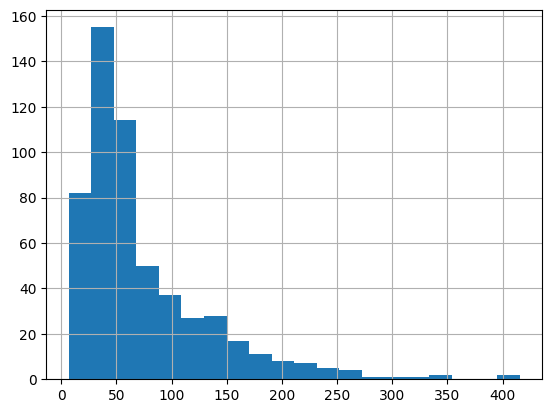

In [58]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [59]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [60]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [61]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [62]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [63]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [64]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [65]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [66]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [67]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 552


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
110,PEP 8,No Trailing Whitespace: Ensure that there are ...,722b5f984403e1f6cd11dcc77696eecf,-405.623240,-136.406886,405.623240,2591.730829,0.778895,0,0
114,PEP 8,No Spaces Around = for Keyword Arguments: Do n...,cdb0fcd9b19b266842b0c49519d735a6,-206.474626,-136.406886,405.623240,2591.730829,0.778895,3,0
118,PEP 8,Spaces in Slices and Function Parameters: Do n...,cd398c511bdf367e157ed38768447784,-155.974633,-136.406886,405.623240,2591.730829,0.778895,6,0
124,PEP 8,Keep Imports at the Top: Ensure all import sta...,ac82992318dccd2ab7da3f6551edf66a,-103.081037,-136.406886,405.623240,2591.730829,0.778895,9,0
288,PEP 8,Limit the Use of Inline Comments: Use inline c...,7d4f60b7dfcce1d879b0908ec82000aa,-78.669518,-136.406886,405.623240,2591.730829,0.778895,12,0
291,PEP 8,Consistent Alignment in Continuation Lines: Al...,c4ec2816ddacfbb9db4d1d3c67c19f03,-53.231151,-136.406886,405.623240,2591.730829,0.778895,15,0
298,PEP 8,Blank Lines Within Functions: Use single blank...,17de6f65ae5e4b18f6bea7bc5a5d6b2e,-38.308643,-136.406886,405.623240,2591.730829,0.778895,18,0
100,SharePoint,"How can you delete a file named ""OldReport.doc...",2a6301873609e19313c38a87765ebb41,-415.525129,-122.665439,415.525129,2085.312458,0.227247,0,0
103,SharePoint,"Whenever possible, the URI for these REST endp...",9837f7465e8ca357b13ad53bca3256ec,-163.167406,-122.665439,415.525129,2085.312458,0.227247,3,0
106,SharePoint,The __metadata property specifies the type inf...,1dae8898917850f6d5ec6f2849f27234,-130.477649,-122.665439,415.525129,2085.312458,0.227247,6,0


## Age Max

In [68]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [69]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [70]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [71]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
110,PEP 8,No Trailing Whitespace: Ensure that there are ...,722b5f984403e1f6cd11dcc77696eecf,-405.623240,-136.406886,405.623240,2591.730829,0.778895,0,0
114,PEP 8,No Spaces Around = for Keyword Arguments: Do n...,cdb0fcd9b19b266842b0c49519d735a6,-206.474626,-136.406886,405.623240,2591.730829,0.778895,3,0
118,PEP 8,Spaces in Slices and Function Parameters: Do n...,cd398c511bdf367e157ed38768447784,-155.974633,-136.406886,405.623240,2591.730829,0.778895,6,0
124,PEP 8,Keep Imports at the Top: Ensure all import sta...,ac82992318dccd2ab7da3f6551edf66a,-103.081037,-136.406886,405.623240,2591.730829,0.778895,9,0
288,PEP 8,Limit the Use of Inline Comments: Use inline c...,7d4f60b7dfcce1d879b0908ec82000aa,-78.669518,-136.406886,405.623240,2591.730829,0.778895,12,0
291,PEP 8,Consistent Alignment in Continuation Lines: Al...,c4ec2816ddacfbb9db4d1d3c67c19f03,-53.231151,-136.406886,405.623240,2591.730829,0.778895,15,0
298,PEP 8,Blank Lines Within Functions: Use single blank...,17de6f65ae5e4b18f6bea7bc5a5d6b2e,-38.308643,-136.406886,405.623240,2591.730829,0.778895,18,0
100,SharePoint,"How can you delete a file named ""OldReport.doc...",2a6301873609e19313c38a87765ebb41,-415.525129,-122.665439,415.525129,2085.312458,0.227247,0,0
103,SharePoint,"Whenever possible, the URI for these REST endp...",9837f7465e8ca357b13ad53bca3256ec,-163.167406,-122.665439,415.525129,2085.312458,0.227247,3,0
106,SharePoint,The __metadata property specifies the type inf...,1dae8898917850f6d5ec6f2849f27234,-130.477649,-122.665439,415.525129,2085.312458,0.227247,6,0


In [72]:
existing_cards['age'].mean()

-74.48922097099047